# Fast Fourier Transform

As we have seen in the previous section, we can calculate $C_k$ via harmonic analysis (i.e. as per the analytic solutions for the discrete Fourier transform to get $A_k$ and $B_k$).

We also saw that it is fairly easy to code, but, in practice, it is not very efficient. From this point onward, we will use the **Fast Fourier Transform** (FFT) algorithm to compute the discrete power spectrum. FFT is a widely available numerical routine and [takes advantage of redundancies in the calculation of $A_k$ and $B_k$ to speed up the process](https://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/). 

## A Note about the Complex Fourier Transform

Until now, we have expressed the Fourier Transform using *real* arithmetic (sines and cosines); however, it is much more efficient to write the Fourier Transform using *complex* arithmetic and using radial frequency, $\omega$, rather than wavenumber:

$$
Y(\omega) = \int_{-\infty}^{\infty} y(t)e^{-i\omega t} \,dt
$$


where $Y(\omega)$ is the Fourier Transfrom of a time series $y(t)$, $\omega$ is the radial frequency (radians per units time), and $Y(\omega)$ is generally a complex number and $i = \sqrt{-1}$.

To convert from the frequency domain back to the time domain, we use the inverse Fourier Transform:

$$
y(t) = \frac{1}{2\pi}\int_{-\infty}^{\infty} Y(\omega)e^{i\omega t} \,d\omega
$$

Let's take a look at how we use the `np.fft.fft` function in python using a simple example.

In [1]:
# load packages
import numpy as np
import scipy.stats as st
from matplotlib import pyplot as plt
import matplotlib as mpl
import pickle
mpl.rc('font',size=16,weight='bold') #set default font size and weight for plots

Here, we will load in time series of the climatological sea level pressure (SLP) and climatological SLP anomaly at 33$^{\circ}$N and 170$^{\circ}$E (the middle of then North Pacific) at daily temporal resolution.

In [2]:
# read .pickle file
infile = open('Ps.pickle','rb')
ps_anom,ps = pickle.load(infile)
infile.close()

Let's plot these time series to see what they look like.

Text(0.5, 1.0, 'Anomalous SLP at 33N, 170E')

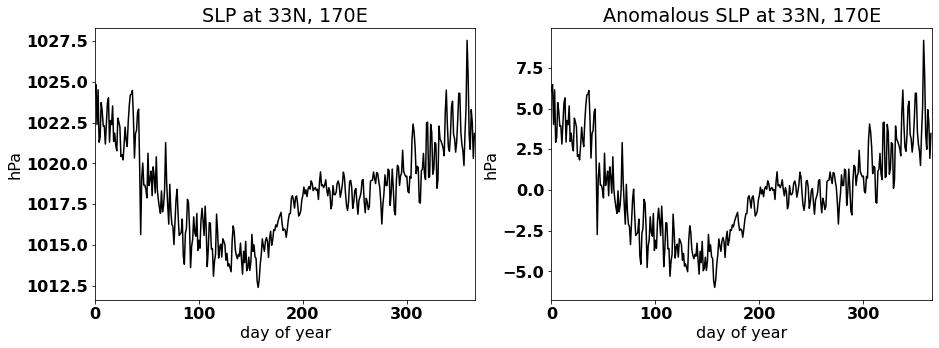

In [3]:
# plot climatology and anomaly
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0,len(ps)),ps,'-k')
plt.ylabel('hPa')
plt.xlabel('day of year')
plt.xlim(0,366)
plt.title('SLP at 33N, 170E')

plt.subplot(1,2,2)
plt.plot(np.arange(0,len(ps)),ps_anom,'-k')
plt.ylabel('hPa')
plt.xlabel('day of year')
plt.xlim(0,366)
plt.title('Anomalous SLP at 33N, 170E')

We will now use the FFT function in numpy to calculate the Discrete Fourier Transform of the climatological SLP anomaly, `ps_anom`.

In [4]:
# calculate discrete fourier transform of X
Z = np.fft.fft(ps_anom)

This function returns the complex fourier transform.

It can be shown, using [Parseval's theorem](https://en.wikipedia.org/wiki/Parseval%27s_theorem#:~:text=In%20mathematics%2C%20Parseval's%20theorem%20usually,the%20square%20of%20its%20transform.), that the square of a time series integrated over time is equal to the square (inner product) of the Fourier Transform integrated over frequency. We can use this theorem to test that our FFT approximately reproduces the variance in `ps_anom`.

We compute the power, i.e. $\frac{C_k^2}{2}$ as follows,

In [5]:
# to get the right variance, we need to normalize Z by N.
Zfft = Z/len(ps_anom)

# next, we calculate the power: the square of absolute value of complex fourier transform
Ck2 = np.abs(Zfft)**2

Note: the below is the same thing but just take over half of the symmetric FFT output. Thus, we multiply by 2. You are probably wondering what I mean by "symmetric" FFT. We will explore the symmetric nature for the FFT further below.

In [6]:
# compute power over half the FFT output
Ck2 = 2*np.abs(Zfft[0:int(len(ps_anom)/2)+1])**2

Now, we compute the sum over all frequencies to get the estimated variance and compare it to the variance of the original time series.

In [7]:
# checking the variance compared to the total variance in our spectrum
# i.e, checking Parseval's Theorem

# actual variance of your data
var_actual = np.var(ps_anom)

# variance in your spectrum, it should be close to the actual variance of your data
var_spectrum = np.sum(Ck2)

print(np.round(var_actual,5), np.round(var_spectrum,5))

8.02768 8.02893


Pretty close!

To get a better sense of the output of the FFT and its symmetric nature, let's plot the power as a function of frequency.

(-5.0, 370.0)

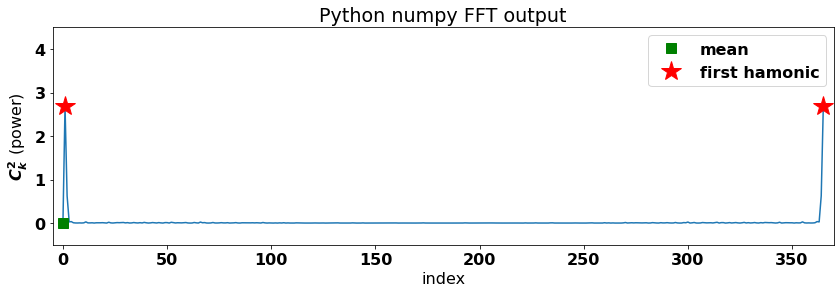

In [8]:
# plot the FFT power

plt.figure(figsize=(14,4))

# plot blue line
plt.plot(np.arange(0,np.size(Zfft)),np.abs(Zfft)**2)

# plot markers
plt.plot(0,np.abs(Zfft[0])**2.,'sg',markersize=10,label='mean')
plt.plot(1,np.abs(Zfft[1])**2.,'*r',markersize=20,label='first hamonic')
plt.plot(np.size(Zfft)-1,np.abs(Zfft[-1])**2.,'*r',markersize=20)

plt.xlabel('index')
plt.ylabel('$C_k^2$ (power)')

plt.title('Python numpy FFT output')
plt.legend()

plt.ylim(-.5,4.5)
plt.xlim(-5,365+5)

What do we get?

Notice that we have two peaks (denoted by red stars) of equal magnitude at either end of the plot. These peaks correspond to the lowest frequency, the annual cycle. The green square denotes the mean, i.e. the value for a frequency of zero.

In theory the Fourier transform results from integrating over -$\infty$ to +$\infty$ and, thus, of the FFT algorithm spans both negative and positive frequencies and is symmetric about the Nyquist frequency. However, in practice, we only have positive frequencies, so we typically just plot the FFT output corresponding to the positive frequencies (as we did in the previous section when we did the calculation from scratch) and scale up the power by a factor of two to distribute all the power to the positive frequencies. 

The plot below demonstrates this for the climatological SLP anomaly time series.

Text(0.5, 1.0, 'Normalized Discrete Power Spectrum')

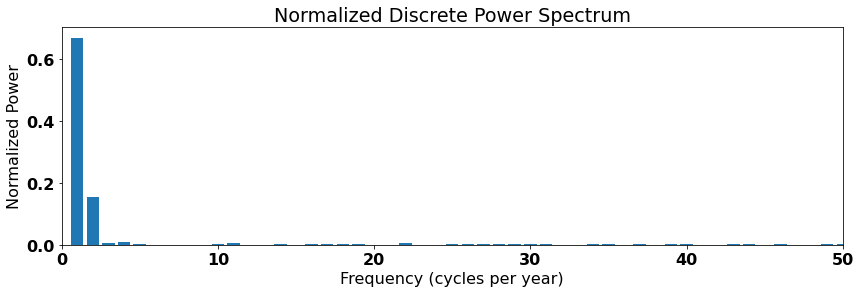

In [9]:
# combine symmetric parts of the FFT and plot the power spectrum as a function of frequency

# create frequency variable for plotting
freq = np.arange(0,int(len(ps_anom)/2)+1)

# plot power just up to freq = 50 cycles per year
plt.figure(figsize=(14,4))
plt.bar(freq,Ck2/np.sum(Ck2))
plt.ylabel('Normalized Power')
plt.xlabel('Frequency (cycles per year)')
plt.xlim(0,50)
plt.title('Normalized Discrete Power Spectrum')

We see that the most power is contained in the 1-2 cycles per year range, i.e. the annual cycle and the semi-annual cycle.

## The Inverse Fourier Transform

Let's now take a look at applying the **Inverse Fourier Transform**, i.e. converting from the frequency domain back to the time domain. In practice, we often take the Fourier Transform of a time series in order to isolate and filter out certain frequencies. Here, we will use the Inverse Fourier Transform (`np.fft.ifft`) to separate the low and high frequencies in our data.

The aim is to separate the three lowest frequencies from all the higer frequencies. To help us visualize what we want to do, the plot below shows the section of the power spectrum that we want to isolate.

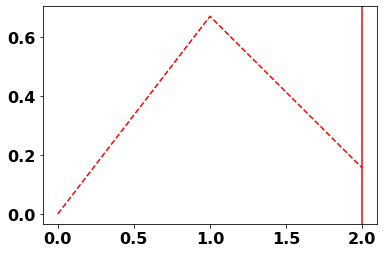

In [10]:
# plot spectrum and how we will only retain the first 3 harmonics (which includes the mean)

# plot vertical line showing the frequency cut-off
plt.axvline(freq[2],color ='r', linewidth = 1.5)

# compute normalized power
A = Ck2/np.sum(Ck2)

# set power to zero at frequencies above 2 cycles per year
A[3::] = 0.

# plot power for lowest frequencies
plt.plot(freq[0:3],A[0:3],'--r')

In essence, we want to retain the power at the lowest frequencies, but set the power of the higher frequencies to zero. No problem - we can do this manually in python.

In [11]:
# low-pass filter: retain only the mean and the first two harmonics, set all other frequencies to zero
# Note that we use the unnormalized FFT output here as this is what we want to plug into our inverse fft.

Z_lp = np.copy(Z)
Z_lp[3:-2:] = 0.0  # we have to set both the positive and negative frequencies to zero

Now, we apply the Inverse FFT to isolate the low-frequency component of the time series.

In [12]:
# apply inverse fourier transform to convert back to time domain (just want the real part)
ps_anom_lp = np.real(np.fft.ifft(Z_lp))

We can do the same thing for the high-frequencies.

In [13]:
# high-pass filter: remove everything that we didn't remove before
Z_hp = np.copy(Z)
Z_hp[0:3] = 0
Z_hp[-2:] = 0

# apply inverse fourier transform to convert back to time domain
ps_anom_hp = np.real(np.fft.ifft(Z_hp))

To check that we indeed isolated the low- and high-frequency components, let's plot the different components of the time series.

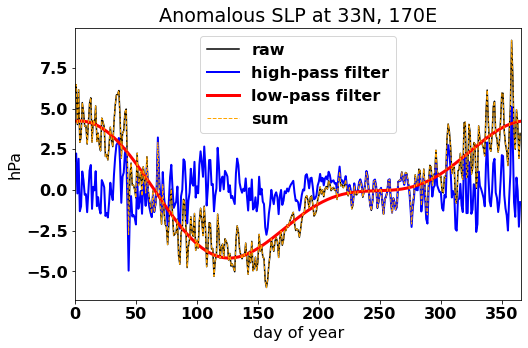

In [14]:
# plot climatological SLP anomaly
plt.figure(figsize=(8,5))
plt.plot(np.arange(0,len(ps_anom)),ps_anom,'-k',label='raw')
plt.ylabel('hPa')
plt.xlabel('day of year')
plt.xlim(0,366)
plt.title('Anomalous SLP at 33N, 170E')

# plot high-pass time series
plt.plot(np.arange(0,len(ps_anom)), ps_anom_hp ,'-b',linewidth = 2, label='high-pass filter')

#  plot low-pass time series
plt.plot(np.arange(0,len(ps_anom)), ps_anom_lp ,'-r',linewidth = 3, label ='low-pass filter')

# plot sum of low pass and high pass
plt.plot(np.arange(0,len(ps_anom)), ps_anom_lp + ps_anom_hp  ,'--',color = 'orange',linewidth = 1, label='sum')

plt.legend()

As you can see, converting to the frequency domain allows for greater specificity in terms of how we filter time series data. We can plot the power spectrum, identify and isolate frequencies that contain varying degrees of power and then use the inverse fourier transform to convert back to the time domain. 

There is more to say on the topic of filtering and we will come back to this in the subsequent sections.

For now, we will move on from Discrete Fourier Transforms (DFT) and consider a more statistically and physically meaningful quantity, the **Continous Fourier Transform**.